In [1]:
from tectosaur2.nb_config import setup

setup()


In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tectosaur2 import panelize_symbolic_surface, gauss_rule, integrate_term
from tectosaur2.laplace2d import hypersingular, adjoint_double_layer, double_layer, single_layer
from tectosaur2.hmatrix import build_tree

t = sp.var("t")
surf = panelize_symbolic_surface(t, 0 * t, t, gauss_rule(6), n_panels=1000)
kernel = hypersingular


In [3]:
%%time
mat = kernel.direct(surf.pts, surf)[:, :, :, 0].reshape((-1, surf.n_pts))

CPU times: user 403 ms, sys: 461 ms, total: 864 ms
Wall time: 864 ms


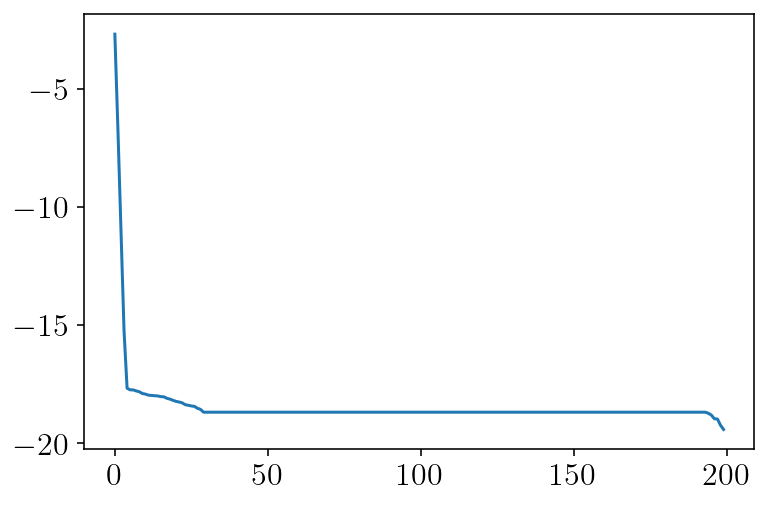

In [4]:
# plt.plot(np.log10(np.linalg.svd(mat)[1]))
plt.plot(np.log10(np.linalg.svd(mat[-200:, :200])[1]))
plt.show()


In [5]:
U, S, V = np.linalg.svd(mat[-200:, :200])
np.argmax(S < 1e-10)


2

In [6]:
%%time
tree = build_tree(surf.pts, np.zeros(surf.n_pts), min_pts_per_box=30)
print("center =", tree.root.center)
print("radius =", tree.root.radius)

center = [0.00000000e+00 9.05571914e-17]
radius = 0.9999324695142032
CPU times: user 32.5 ms, sys: 19.1 ms, total: 51.6 ms
Wall time: 14.9 ms


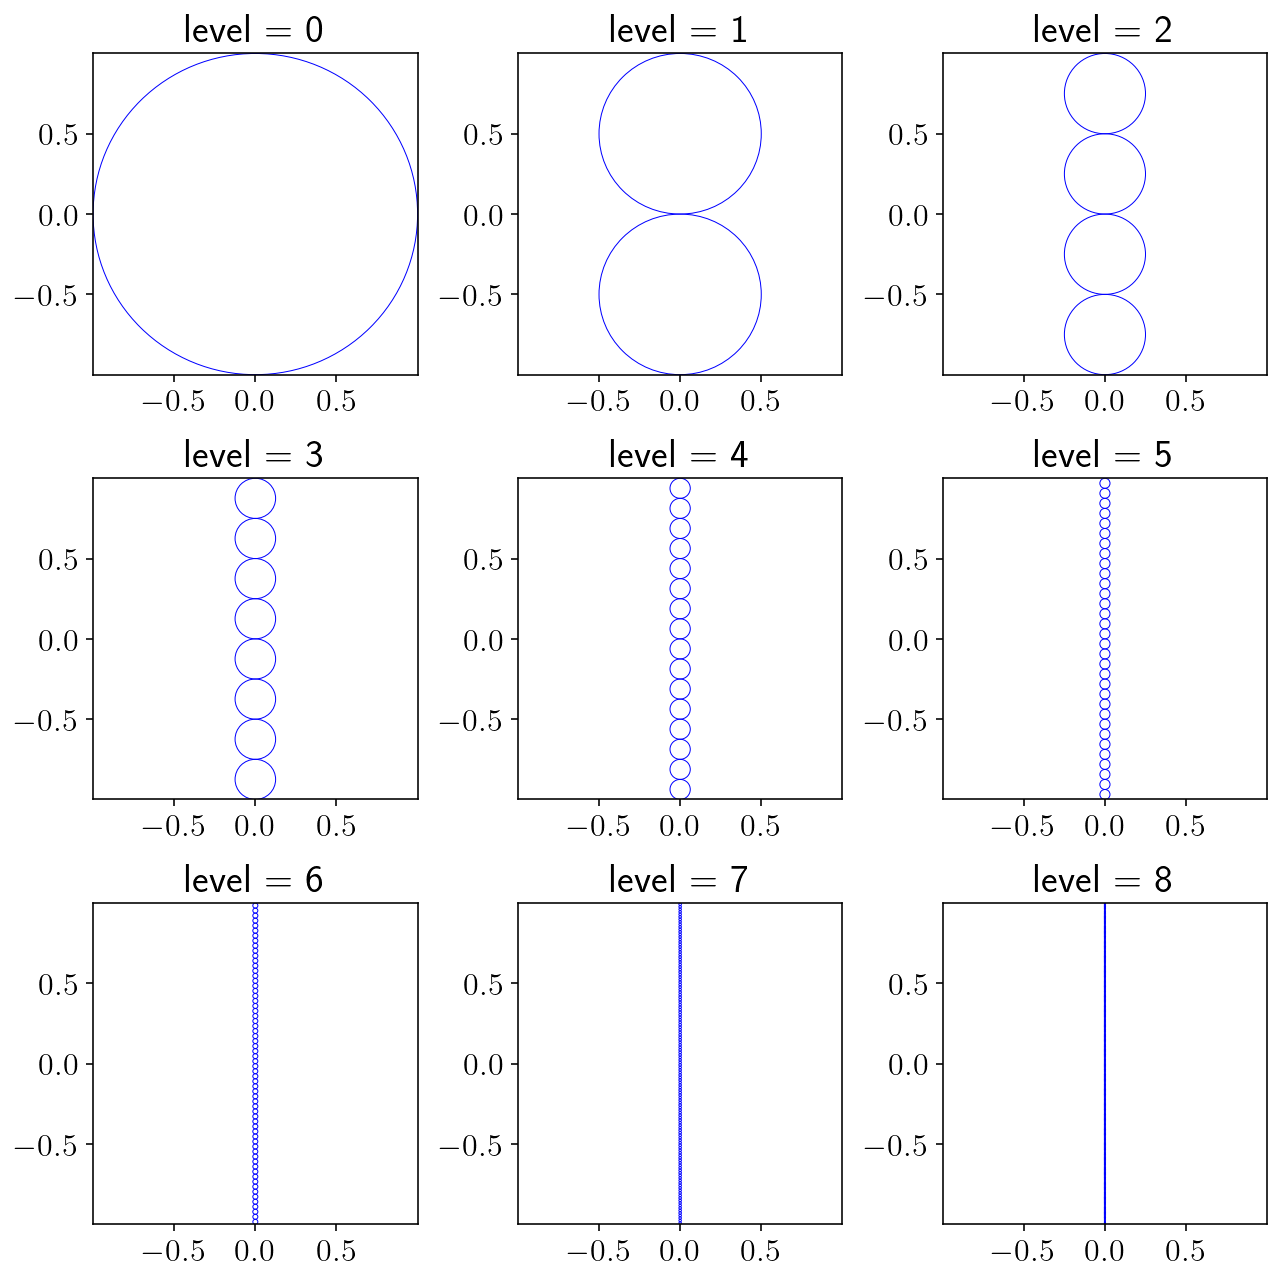

In [7]:
%matplotlib inline
from tectosaur2.hmatrix.tree import plot_tree
plot_tree(tree)

In [8]:
from tectosaur2.hmatrix import traverse

direct, approx = traverse(tree.root, tree.root)


In [9]:
from tectosaur2.hmatrix import TempSurface, build_temp_surface, approx_block_toy_aca

tree_surf = TempSurface(
    surf.pts[tree.ordered_idxs],
    surf.normals[tree.ordered_idxs],
    surf.quad_wts[tree.ordered_idxs],
    surf.jacobians[tree.ordered_idxs],
)


def direct_block(obs_node, src_node):
    temp_src = build_temp_surface(tree_surf, src_node.idx_start, src_node.idx_end)
    obs_pts = tree_surf.pts[obs_node.idx_start : obs_node.idx_end]
    M = kernel.direct(obs_pts, temp_src)
    return M.reshape(
        (
            obs_pts.shape[0] * kernel.obs_dim,
            (src_node.idx_end - src_node.idx_start) * kernel.src_dim,
        )
    )


In [10]:
%%time
direct_blocks = [direct_block(d[0], d[1]) for d in direct]

CPU times: user 19.3 ms, sys: 1.73 ms, total: 21 ms
Wall time: 20.4 ms


In [11]:
%%time
approx_blocks = [approx_block_toy_aca(kernel, tree_surf.pts, tree_surf, d[0], d[1], 1e-10) for d in approx]

CPU times: user 1.56 s, sys: 360 ms, total: 1.92 s
Wall time: 807 ms


In [12]:
direct_block(*approx[0]).shape


(46, 23)

In [13]:
v = np.random.rand(mat.shape[1])


In [14]:
%%time
ytrue = mat.dot(v).reshape((-1, kernel.obs_dim))


CPU times: user 45.2 ms, sys: 55.3 ms, total: 100 ms
Wall time: 13 ms


In [15]:
%%time
ytree = np.zeros(mat.shape[0])
treev = v[tree.ordered_idxs]

for i, (obs_node, src_node) in enumerate(direct):
    ytree[kernel.obs_dim*obs_node.idx_start:kernel.obs_dim*obs_node.idx_end] += direct_blocks[i].dot(treev[src_node.idx_start:src_node.idx_end])

for i, (obs_node, src_node) in enumerate(approx):
    v_subset = treev[src_node.idx_start:src_node.idx_end]
    U, V = approx_blocks[i] 
    ytree[kernel.obs_dim*obs_node.idx_start:kernel.obs_dim*obs_node.idx_end] += U.dot(V.dot(v_subset))

yh = np.zeros((mat.shape[0] // kernel.obs_dim, kernel.obs_dim))
yh[tree.ordered_idxs] = ytree.reshape((-1, kernel.obs_dim))
yh[:10] - ytrue[:10]

CPU times: user 17.6 ms, sys: 8.57 ms, total: 26.2 ms
Wall time: 8.05 ms


array([[-7.38964445e-12, -3.65048702e-17],
       [-3.58113539e-12, -1.10292626e-21],
       [ 4.54747351e-13,  1.55365435e-23],
       [ 1.13686838e-13,  1.04824964e-27],
       [-1.02318154e-12,  0.00000000e+00],
       [-4.54747351e-13,  0.00000000e+00],
       [-4.54747351e-13,  0.00000000e+00],
       [-3.63797881e-12,  0.00000000e+00],
       [-5.22959454e-12,  0.00000000e+00],
       [-4.71800377e-12,  0.00000000e+00]])

In [16]:
approx_entries = sum(
    [U.shape[0] * U.shape[1] + V.shape[0] * V.shape[1] for U, V in approx_blocks]
)
direct_entries = sum([M.shape[0] * M.shape[1] for M in direct_blocks])
(approx_entries + direct_entries) / mat.size


0.038679430555555554

In [17]:
for i, (obs_node, src_node) in enumerate(approx[:3]):
    U, V = approx_blocks[i]
    print(
        np.sqrt(
            np.sum(
                (
                    mat[
                        kernel.obs_dim
                        * obs_node.idx_start : kernel.obs_dim
                        * obs_node.idx_end,
                        kernel.src_dim
                        * src_node.idx_start : kernel.src_dim
                        * src_node.idx_end,
                    ]
                    - U.dot(V)
                )
                ** 2
            )
        )
    )


2.5661647778957052e-11
8.960104180030024e-12
2.7796420218408977e-11


In [19]:
%%time
tol = 1e-10
blocks = approx[:]
approx_obs_starts = np.array([b[0].idx_start for b in blocks])
approx_obs_ends = np.array([b[0].idx_end for b in blocks])
approx_src_starts = np.array([b[1].idx_start for b in blocks])
approx_src_ends = np.array([b[1].idx_end for b in blocks])

approx_blocks_aca = [uv for uv in aca(
    kernel,
    approx_obs_starts,
    approx_obs_ends,
    approx_src_starts,
    approx_src_ends,
    tree_surf.pts,
    tree_surf,
    np.full(len(approx), tol), 
    np.full(len(approx), 200, dtype=np.int32), 
    verbose=False
)]

CPU times: user 270 ms, sys: 189 ms, total: 460 ms
Wall time: 167 ms


In [24]:
approx_blocks[0][0].shape, approx_blocks_aca[0][0].shape


((46, 7), (46, 7))

In [95]:
for i, (obs_node, src_node) in enumerate(approx):
    U, V = approx_blocks_aca[i]
    # print(U.shape, V.shape)
    print(
        np.sqrt(
            np.sum(
                (
                    mat[
                        kernel.obs_dim
                        * obs_node.idx_start : kernel.obs_dim
                        * obs_node.idx_end,
                        kernel.src_dim
                        * src_node.idx_start : kernel.src_dim
                        * src_node.idx_end,
                    ]
                    - U.dot(V)
                )
                ** 2
            )
        )
    )


3.688209901823206e-12
2.7059580386830375e-11
3.0836022724928006e-12
2.366293824533172e-11
3.1391367884622104e-11
2.464832539736078e-11
3.345453801651139e-12
4.087167293511586e-12
2.8112518206477073e-11
2.028225490941604e-11
3.3454524082356766e-12
4.626256903904842e-12
1.4366090459153643e-12
2.3785622043636096e-11
1.5668519108727916e-12
2.9686204890466536e-11
4.040208259552856e-11
3.000571480505668e-12
3.154045256655711e-11
5.1013703796021566e-12
5.5952406501077546e-11
4.536572251125396e-12
4.344752748437839e-11
4.12099246548554e-12
3.9635883533775507e-11
5.102682007820651e-12
4.8920085305037645e-11
4.379105621379295e-12
3.687748382969594e-12
2.707797519451707e-11
3.0836022724928006e-12
2.364585909501039e-11
3.13709596943891e-11
2.4674399977006422e-11
3.3454528512255348e-12
4.087167455420933e-12
2.8089314938367208e-11
2.029712867660879e-11
3.3454516182939294e-12
4.618743153257659e-12
1.4366090459153643e-12
2.3785623791706535e-11
1.5668515040580162e-12
2.968620611571375e-11
4.66724473577